# Imports

In [1]:
import sys
import os
from pathlib import Path
import itertools
import shutil
import time
import h5py
import scipy
from itertools import cycle, islice
from datetime import datetime

import torch
from torchvision import transforms
from torchvision.datasets.folder import default_loader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact

import IPython
from IPython.display import Markdown, display, YouTubeVideo

from tqdm.notebook import tqdm

In [2]:
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_colwidth = 300

In [3]:
sys.path.append('/Users/staveshemesh/Projects/shstav2/token_voken/src')
sys.path.append('/Users/staveshemesh/Projects/shstav2/token_voken')

In [4]:
from src.setup import syspath_append_projects

In [5]:
syspath_append_projects()

# Helpers

## Paths Resolvers

In [6]:
from src.path_resolvers import *

## Display Utils

In [7]:
from src.display_utils import *

## Constants

In [8]:
FRAME_RATE = 15
SAMPLE_INTERVAL = '214625'
SPEAKER_NAME = 'oliver'
TAB = '&nbsp;&nbsp;&nbsp;&nbsp;'

# Read Data

## Constants for Paths

In [9]:
DATA_ROOT = '/Users/staveshemesh/Projects/shstav2/token_voken/data/'
INTERVALS_FILE = '20210506_135358_df_intervals_batch1_431.csv'
INTERVALS_PATH = os.path.join(DATA_ROOT, INTERVALS_FILE)

PATS_DATA_ROOT = '/Users/staveshemesh/Projects/PATS_DATA/'
PATS_SPEAKER_VIZ_DIR = os.path.join(PATS_DATA_ROOT, f'Youtube/{SPEAKER_NAME}')
PATS_SPEAKER_DATA_DIR = os.path.join(PATS_DATA_ROOT, f'Processed/{SPEAKER_NAME}/data')
PATS_SPEAKER_PATS_INTERVAL_DIR = os.path.join(PATS_SPEAKER_DATA_DIR, 'processed', SPEAKER_NAME)

# Output files:
#   1. DataFrames
#   2. Model Input files
# Output Dir
TIMESTR = time.strftime("%Y%m%d_%H%M%S")
#  Model Input files
# OUTPUT_TOKENS_PATH = os.path.join(OUTPUT_ITERATION_DIR, 'sample_token_ids_{count}.hdf5')
# OUTPUT_VOKENS_PATH = os.path.join(OUTPUT_ITERATION_DIR, 'sample_voken_ids_{count}.hdf5')
# OUTPUT_VOKEN_IDS_PATH = os.path.join(OUTPUT_ITERATION_DIR, '{dataset}_{count}.ids')
# OUTPUT_VOKEN_KEYS_PATH = os.path.join(OUTPUT_ITERATION_DIR, 'keys')

## DataFrames

In [10]:
DATASET_FILE = '20210510_190411_df_dataset_batch1_15659.csv'
DATASET_PATH = os.path.join(DATA_ROOT, DATASET_FILE)

In [11]:
df_dataset_all = pd.read_csv(DATASET_PATH, dtype={'interval_id': object})

In [12]:
df_dataset_all.columns

Index(['word_original', 'bert_token', 'token_id', 'frame_selected', 'voken_id',
       'interval_id', 'offset_start', 'offset_end', 'word_time',
       'word_len_plus_1', 'word_start', 'word_end', 'frame_start', 'frame_end',
       'frame_count', 'frame_path', 'frame_face_path', 'video_id',
       'interval_time'],
      dtype='object')

In [14]:
df_dataset_all['has_face_frame'] = df_dataset_all['frame_face_path'].apply(os.path.exists)
df_with_caption(df_dataset_all['has_face_frame'].value_counts().to_frame(), 'Existing Frames')

,has_face_frame
True,7970
False,7689


In [15]:
df_dataset = df_dataset_all[df_dataset_all['has_face_frame']]

In [16]:
from models.FECNet import FECNet

class VisnFECNetModel(torch.nn.Module):
    def __init__(self, arch='fecnet', pretrained=True):
        """
        :param dim: dimension of the output
        :param arch: backbone architecture,
        :param pretrained: load feature with pre-trained vector
        :param finetuning: finetune the model
        """
        super().__init__()
        fecnet = FECNet(pretrained=True) # Setup Backbone
        for param in fecnet.parameters():
            param.requires_grad = False
        self.backbone = fecnet

    def forward(self, img):
        """
        :param img: a tensor of shape [batch_size, H, W, C]
        :return: a tensor of [batch_size, d]
        """
        x = self.backbone(img)
        x = x.detach()
        # x = x / x.norm(2, dim=-1, keepdim=True)
        return x

In [17]:
visn_model = VisnFECNetModel(arch='fecnet').eval()
assert visn_model.backbone.training == False
assert visn_model.training == False

In [18]:
img_sets = [SPEAKER_NAME]
img_paths = df_dataset['frame_face_path'].tolist()
img_ids = df_dataset['voken_id'].tolist()
img_transform = transforms.Compose([transforms.ToTensor()])
batch_size = 32

In [19]:
saved_img_paths = []
saved_img_ids = []
img_keys = []
tensor_imgs = []
debug_count = 0
last_dim = -1

for i, img_path in enumerate(tqdm(img_paths)):
    try:
        pil_img = default_loader(img_path)
        saved_img_paths.append(img_path)
        saved_img_ids.append(img_ids[i])
        img_tensor = img_transform(pil_img)
        tensor_imgs.append(img_tensor)
        # debug
        if i < 5000 and debug_count < 10:
            debug_count += 1
            print("Loaded image %s" % img_path)
    except Exception as e:
        if str(SAMPLE_INTERVAL) in img_path:
            print(e)
            print("Skip image %s" % img_path)
        continue

    if len(tensor_imgs) == batch_size:
        visn_input = torch.stack(tensor_imgs)
        with torch.no_grad():
            visn_output = visn_model(visn_input)

        # Check sizes of features are equal.
        if last_dim == -1:
            last_dim = visn_output.shape[-1]
        assert last_dim == visn_output.shape[-1]
        last_dim = visn_output.shape[-1]

        # Saved the features in hdf5
        img_keys.extend(visn_output.detach().cpu().numpy())

        tensor_imgs = []

if len(tensor_imgs) > 0:
    visn_input = torch.stack(tensor_imgs)
    with torch.no_grad():
        visn_output = visn_model(visn_input)
    # Saved the features in hdf5
    img_keys.extend(visn_output.detach().cpu().numpy())

Loaded image /Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00002/detected_face_0.png
Loaded image /Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00006/detected_face_0.png
Loaded image /Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00011/detected_face_0.png
Loaded image /Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00017/detected_face_0.png
Loaded image /Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00033/detected_face_0.png
Loaded image /Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00033/detected_face_0.png
Loaded image /Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/Tt-mpuR_QHQ/100913/vokens/face_annot_224/00048/detected_face_0.png
Loaded image /Users/staveshemesh/Projects/PATS_DATA/Youtube/ol

In [24]:
len(tensor_imgs)

8

In [29]:
len(img_keys)

5128

In [31]:
batch_size

32

In [30]:
img_keys[10].shape

(16,)

## Similarities

In [49]:
def is_symmetric(A, tol=1e-8):
    return np.linalg.norm(A-A.T, scipy.Inf) < tol;

In [50]:
from sentence_transformers import util

In [110]:
cosine_scores = util.pytorch_cos_sim(img_keys, img_keys).numpy()
cosine_scores_without_diag = np.copy(cosine_scores)
np.fill_diagonal(cosine_scores_without_diag, np.nan)

In [117]:
printmd('**Cosine Scores:**')
printmd(f'{TAB}**Shape**: {cosine_scores.shape}')
printmd(f'{TAB}**Symmetric:** {is_symmetric(cosine_scores)}')
printmd(f'{TAB}**Mean:** {cosine_scores.mean():.7f}')
printmd(f'{TAB}**Nan Mean:** {np.nanmean(cosine_scores_without_diag):.7f}')

**Cosine Scores:**

&nbsp;&nbsp;&nbsp;&nbsp;**Shape**: (5128, 5128)

&nbsp;&nbsp;&nbsp;&nbsp;**Symmetric:** True

&nbsp;&nbsp;&nbsp;&nbsp;**Mean:** 0.9467884

&nbsp;&nbsp;&nbsp;&nbsp;**Nan Mean:** 0.9467782

In [65]:
cosine_scores[100][1099]

0.92803365

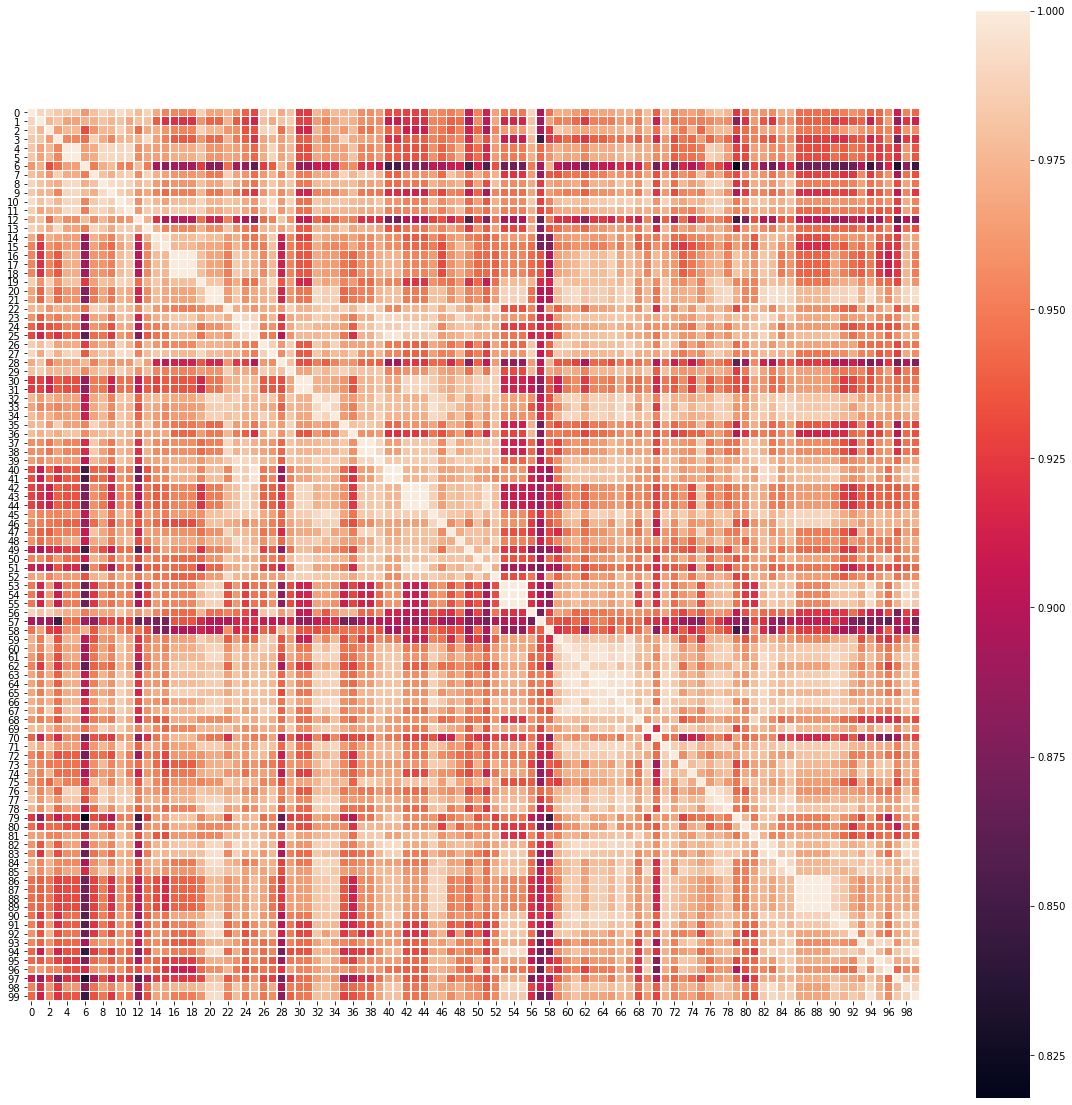

In [70]:
plt.figure(figsize=(20,20))
sns.heatmap(cosine_scores[0:100,0:100], square=True, linewidths=.5);

In [38]:
face_embeddings_similarities = cosine_scores

NameError: name 'cosine_scores' is not defined

In [39]:
face_embeddings_similarities[np.diag_indices_from(face_embeddings_similarities)] = 0.0
idx = np.argsort(face_embeddings_similarities, axis=None)[-10:]
midx = np.unravel_index(idx, face_embeddings_similarities.shape)
print(midx[0])
print(midx[1])
print(face_embeddings_similarities[midx])

NameError: name 'face_embeddings_similarities' is not defined

In [36]:
def examine_frame_pair(interval_id, frame_id1, frame_id2):
    simlarity = face_embeddings_similarities[frame_id1,frame_id2]
    assert face_embeddings_similarities[frame_id1,frame_id2] == face_embeddings_similarities[frame_id2,frame_id1]
    print(f'simlarity: {simlarity:.5f}')
    display_voken(interval_id=interval_id, frame_id=frame_id1)
    display_voken(interval_id=interval_id, frame_id=frame_id2)

def display_voken(interval_id, frame_id):
    voken_path = resolve_224_voken_path(interval_id=interval_id, frame_id=frame_id)
    print(voken_path)
    display(IPython.display.Image(voken_path))

In [37]:
examine_frame_pair('214625', 52, 64)

NameError: name 'face_embeddings_similarities' is not defined

# Export Data

In [79]:
img_keys_2d = np.stack(img_keys)

In [94]:
facenet_filename = f'fecnet_embeddings_{img_keys_2d.shape[0]}x{img_keys_2d.shape[1]}_{TIMESTR}.npy'
fecnet_embeddings_path = os.path.join(DATA_ROOT, facenet_filename)
np.save(fecnet_embeddings_path, img_keys_2d)
printmd(f'{TAB}**Embeddings** → {fecnet_embeddings_path}..')

&nbsp;&nbsp;&nbsp;&nbsp;**Embeddings** → /Users/staveshemesh/Projects/shstav2/token_voken/data/fecnet_embeddings_5128x16_20210511_122252.npy..

## DataFrames

In [45]:
os.makedirs(OUTPUT_DATAFRAMES_ITERATION_DIR)

In [46]:
# df_dataset
rows_df_dataset = df_dataset.shape[0]
path_df_dataset = os.path.join(OUTPUT_DATAFRAMES_ITERATION_DIR, f'{TIMESTR}_df_dataset_{rows_df_dataset}.csv')
printmd(f'{TAB}**df_dataset** → {rows_df_dataset:,} rows {path_df_dataset}')
df_dataset.to_csv(path_df_dataset, header=True)

# df_token_voken
rows_df_token_voken = df_token_voken.shape[0]
path_df_token_voken = os.path.join(OUTPUT_DATAFRAMES_ITERATION_DIR, f'{TIMESTR}_df_token_voken_{rows_df_token_voken}.csv')
printmd(f'{TAB}**df_token_voken** → {rows_df_token_voken:,} rows {path_df_token_voken}')
df_token_voken.to_csv(path_df_token_voken, header=True)

# df_interval_text
rows_df_interval_text = df_interval_text.shape[0]
path_df_interval_text = os.path.join(OUTPUT_DATAFRAMES_ITERATION_DIR, f'{TIMESTR}_df_interval_text_{rows_df_interval_text}.csv')
printmd(f'{TAB}**rows_df_interval_text** → {rows_df_interval_text:,} rows {path_df_interval_text}')
df_interval_text.to_csv(path_df_interval_text, header=True)

display(df_with_caption(df_dataset.head(), 'df_dataset'))
display(df_with_caption(df_token_voken.head(), 'df_token_voken'))
display(df_with_caption(df_interval_text.head(), 'df_interval_text'))

&nbsp;&nbsp;&nbsp;&nbsp;**df_dataset** → 6,185 rows /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/dataframes/20210416_212032_df_dataset_6185.csv

&nbsp;&nbsp;&nbsp;&nbsp;**df_token_voken** → 5,618 rows /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/dataframes/20210416_212032_df_token_voken_5618.csv

&nbsp;&nbsp;&nbsp;&nbsp;**rows_df_interval_text** → 64 rows /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/dataframes/20210416_212032_df_interval_text_64.csv

,word_original,bert_token,token_id,frame_selected,voken_id,interval_id,offset_start,offset_end,word_time,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_full_path,video_id,interval_time
0,are,are,2024,0,1,100983,0,3,0,4,0,3,0,1,1,0_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00000.png,hWQiXv0sn9Y,26.5599
1,not,not,2025,2,2,100983,4,7,0.1,4,4,7,1,4,3,2_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00002.png,hWQiXv0sn9Y,26.5599
2,understanding,understanding,4824,7,3,100983,8,21,0.5,14,8,21,4,10,6,7_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00007.png,hWQiXv0sn9Y,26.5599
3,Liquid,liquid,6381,19,4,100983,22,28,1.3,7,22,28,10,29,19,19_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00019.png,hWQiXv0sn9Y,26.5599
4,Gold,gold,2751,42,5,100983,29,33,2.8,5,29,33,29,56,27,42_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00042.png,hWQiXv0sn9Y,26.5599


,word_original,frame_selected,word_time,word_len_plus_1,word_start,word_end,frame_start,frame_end,frame_count,frame_path,frame_full_path,interval_id,video_id,interval_time
4045,are,0,0,4,0,3,0,1,1,0_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00000.png,100983,hWQiXv0sn9Y,26.5599
4046,not,2,0.1,4,4,7,1,4,3,2_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00002.png,100983,hWQiXv0sn9Y,26.5599
4047,understanding,7,0.5,14,8,21,4,10,6,7_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00007.png,100983,hWQiXv0sn9Y,26.5599
4048,Liquid,19,1.3,7,22,28,10,29,19,19_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00019.png,100983,hWQiXv0sn9Y,26.5599
4049,Gold,42,2.8,5,29,33,29,56,27,42_100983_hWQiXv0sn9Y,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/100983/vokens/face_annot_224/00042.png,100983,hWQiXv0sn9Y,26.5599


,interval_id,text
0,100983,are not understanding Liquid Gold everything about this industry is incredibly difficult to navigate which is dangerous because even one of its own trains groups its own tree groups has wounds that some sectors of it are out of control and percent of just how helpless you can be in the face of old is just listen to Tom McClellan he was a ball as Deputy drugs are you would think that if anyone knows this world it would be him
1,101126,plus it's a phone call so you'll say whatever it takes to make it end cuz getting so but might be hard but nothing is harder than an 8 minute phone call with another human being nothing nothing at all those claims of success it is very hard to know exactly what you're getting at any given rehab 12-step bicep wrote which undoubtedly what's the song with the most experts argue that they should also be consistent access to other newer treatments like sun behavioral therapy
2,101127,medications like these are not required to offer Lowe's because we have to essentially be whatever is proprietor says it is that means they can frame almost anything as treatment for instance many Hawaiians rehabs off of something cold Equine Therapy and again if you respond to that that's great but there is no empirical evidence that as a treatment for addiction it works which means some people who paid a high price for it can end up
3,101174,"true even the nation's Deputy drugs are couldn't confidently navigate their system in the tragedy is his son died and remember the funny guy who hated horses he died too so this is a matter of life and death are you if you're wondering what experts would advise you to do in seeking treatment money that we spoke to suggested beginning not with a rehab which may try and sell you on its own substance but with the doctor who is board certified in addiction medicine now it's only recently become an official specialty so they just aren't many of them around but you can find those the doing sitting out this website here that you may be able to go with you to a treatment the best suits your needs which might well not be a fancy Center where you have to pay $73,000 to have this guy lose you look up this system clearly Berkeley needs more expertise and it might be really important to understand the word rehab is so broadly defined as to be close to meaningless it is honestly barely better defined in the word building and if someone were to tell you I have a drug problem but don't worry I'm going to building in Florida would not"
4,101178,horse ratio like in that I'm so ugly right now it can be way too difficult to get all answers to those questions which is crazy because so much about battling addiction is really hard guessing clean is hard staying clean is hard but getting good evidence-based trustworthy help should be the fucking easy pops and right now it is way too easy to literally one. Pissing


In [47]:
df_dataset['voken_file'] = df_dataset['frame_full_path'].str.slice(47)
SHOW_COLS = ['word_original', 'bert_token', 'frame_selected', 'frame_full_path', 'voken_file']
df_dataset[SHOW_COLS][90:106].style.set_properties(**{'text-align': 'left', 'font-size': '12pt'})

,word_original,bert_token,frame_selected,frame_full_path,voken_file
90,you'll,you,98,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00098.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00098.png
91,you'll,',98,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00098.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00098.png
92,you'll,ll,98,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00098.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00098.png
93,say,say,101,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00101.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00101.png
94,whatever,whatever,105,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00105.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00105.png
95,it,it,109,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00109.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00109.png
96,takes,takes,114,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00114.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00114.png
97,to,to,117,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00117.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00117.png
98,make,make,118,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00118.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00118.png
99,it,it,120,/Users/staveshemesh/Projects/PATS_DATA/Youtube/oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00120.png,oliver/hWQiXv0sn9Y/101126/vokens/face_annot_224/00120.png


## Training Data

## Tokens

### Save tokens.hdf5

In [48]:
token_ids = df_dataset['token_id']
token_output_path = OUTPUT_TOKENS_PATH.format(count=len(token_ids))
with h5py.File(token_output_path, 'w') as hf:
    hf.create_dataset('tokens', data=token_ids)

print(f'Saved {len(token_ids):,} to {token_output_path}.')

Saved 6,185 to /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/sample_token_ids_6185.hdf5.


In [49]:
token_hdf5 = h5py.File(token_output_path, 'r')
token_ids_from_file = token_hdf5['tokens']
print(token_ids_from_file)
token_hdf5.close()

<HDF5 dataset "tokens": shape (6185,), type "<i8">


## Vokens

### Save vokens.hdf5

In [50]:
voken_ids = df_dataset['voken_id'].tolist()

**Save File**

In [51]:
voken_output_path = OUTPUT_VOKENS_PATH.format(count=len(voken_ids))
with h5py.File(voken_output_path, 'w') as hf:
    hf.create_dataset('vokens', data=voken_ids)

printmd(f'{TAB}**voken keys** → {len(voken_ids):,} to {voken_output_path}.')

&nbsp;&nbsp;&nbsp;&nbsp;**voken keys** → 6,185 to /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/sample_voken_ids_6185.hdf5.

**Validate File**

In [52]:
voken_hdf5 = h5py.File(voken_output_path, 'r')
voken_ids_from_file = voken_hdf5['vokens']
print(voken_ids_from_file)
voken_ids_from_file_list = voken_ids_from_file[:].tolist()
assert voken_ids_from_file_list == voken_ids
voken_hdf5.close()

<HDF5 dataset "vokens": shape (6185,), type "<i8">


### Save vokens.ids (vg_nococo/241)

In [53]:
# TODO: use pandas
img_set = img_sets[0]
img_ids = (img_set + '/' + df_vokens['voken_id'].astype(str)).tolist()

ids_path = OUTPUT_VOKEN_IDS_PATH.format(dataset=img_set, count=len(unique_voken_ids))

with open(ids_path, 'w') as f:
    for img_id in img_ids:
        f.write(str(img_id) + '\n')

printmd(f'{TAB}**voken unique ids** → {len(img_ids):,} to {ids_path}.')

&nbsp;&nbsp;&nbsp;&nbsp;**voken unique ids** → 5,611 to /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/oliver_5611.ids.

### Save voken keys

In [54]:
keys_output_dir = OUTPUT_VOKEN_KEYS_PATH
printmd(f'{TAB}**keys dir** → {keys_output_dir}')
os.makedirs(keys_output_dir)

&nbsp;&nbsp;&nbsp;&nbsp;**keys dir** → /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/keys

In [55]:
df_dataset.shape

(6185, 20)

In [56]:
h5_path = os.path.join(keys_output_dir, img_set + '.hdf5')
print(f"\tSave features (keys) to {h5_path} with hdf5 dataset 'Keys'.")
h5_file = h5py.File(h5_path, 'w')
#TODO: TMP. FIXME
TARGET_LEN = df_dataset.shape[0]
dset = h5_file.create_dataset("keys", (TARGET_LEN, last_dim))
# dset = h5_file.create_dataset("keys", (len(saved_img_paths), last_dim))
for i, img_key in enumerate(islice(cycle(img_keys), TARGET_LEN)):
    dset[i] = img_key
h5_file.close()

	Save features (keys) to /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/keys/oliver.hdf5 with hdf5 dataset 'Keys'.


In [57]:
voken_feat_hdf5 = h5py.File(h5_path, 'r')
voken_keys_from_file = voken_feat_hdf5['keys']
print(voken_keys_from_file)
voken_keys_from_file_list = voken_keys_from_file[:].tolist()
assert TARGET_LEN == len(voken_keys_from_file_list)
# assert len(img_keys) == len(voken_keys_from_file_list)
assert all([(img_keys[i] == voken_keys_from_file_list[i]).all() for i in range(len(img_keys))])
print(f'✓ Same Len: {len(img_keys)}')
print(f'✓ Same Features: {len(img_keys)}x{len(img_keys[0])}')
voken_feat_hdf5.close()

<HDF5 dataset "keys": shape (6185, 16), type "<f4">
✓ Same Len: 55
✓ Same Features: 55x16


In [58]:
print(f'Save {len(saved_img_paths):,} feature keys of size {img_keys[0].shape[0]} each.')

Save 55 feature keys of size 16 each.


In [59]:
# Save Image Paths
curr_paths_fname = os.path.join(keys_output_dir, img_set + '.path')
print("\tSave img paths to ", curr_paths_fname)
with open(curr_paths_fname, 'w') as f:
    for path in img_paths:
        f.write(path + "\n")

	Save img paths to  /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/keys/oliver.path


In [60]:
# Save Within Set Image Ids
curr_ids_fname = os.path.join(keys_output_dir, img_set + '.ids')
local_img_ids = df_dataset['voken_id'].tolist()
print("\tSave img ids to ", curr_ids_fname)
with open(curr_ids_fname, 'w') as f:
    for idx in local_img_ids:
        f.write(str(idx) + "\n")

	Save img ids to  /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/keys/oliver.ids


## Show Content

In [61]:
!tree {OUTPUT_ITERATION_DIR}

/Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032
├── dataframes
│   ├── 20210416_212032_df_dataset_6185.csv
│   ├── 20210416_212032_df_interval_text_64.csv
│   └── 20210416_212032_df_token_voken_5618.csv
├── keys
│   ├── oliver.hdf5
│   ├── oliver.ids
│   └── oliver.path
├── oliver_5611.ids
├── sample_token_ids_6185.hdf5
└── sample_voken_ids_6185.hdf5

2 directories, 9 files


List of **unique** voken ids

### Vokens

In [62]:
! echo {curr_ids_fname}
! (head -5 && tail -n5) < {curr_ids_fname}

/Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/keys/oliver.ids
1
2
3
4
5
5608
5609
5610
5610
5611


In [63]:
!cat {OUTPUT_ITERATION_DIR}/keys/pats.path | head -n 5

cat: /Users/staveshemesh/Projects/shstav2/token_voken/data/sample/20210416_212032/keys/pats.path: No such file or directory
